In [257]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import itertools

from sklearn.model_selection import GridSearchCV, KFold, cross_val_score
from sklearn.metrics import accuracy_score, confusion_matrix,ConfusionMatrixDisplay
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import NMF
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

import warnings
warnings.filterwarnings('ignore')

In [38]:
#Import data
train_df = pd.read_csv("BBC News Train.csv")
test_df = pd.read_csv("BBC News Test.csv")


# Exploratory Data Analysis

### Train Data

In [39]:
#Inspect the data
print(train_df.shape)
train_df.info()

#Check for missing data
train_df.isnull().sum()

(1490, 3)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1490 entries, 0 to 1489
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   ArticleId  1490 non-null   int64 
 1   Text       1490 non-null   object
 2   Category   1490 non-null   object
dtypes: int64(1), object(2)
memory usage: 35.0+ KB


ArticleId    0
Text         0
Category     0
dtype: int64

In [40]:
train_df.head()

,ArticleId,Text,Category
0,1833,worldcom ex-boss launches defence lawyers defe...,business
1,154,german business confidence slides german busin...,business
2,1101,bbc poll indicates economic gloom citizens in ...,business
3,1976,lifestyle governs mobile choice faster bett...,tech
4,917,enron bosses in $168m payout eighteen former e...,business


In [41]:
#Category values
np.unique(train_df.Category)

array(['business', 'entertainment', 'politics', 'sport', 'tech'],
      dtype=object)

The train data has 3 columns and 1490 observations.

The article Id column gives an unique identifier of each article and is integer.

The text column shows an excerpt of the article.

The Category column is our target containing the category of the article. The possibile categories include: business, entertainment, politics, sport, and tech.

I noticed the data type of columns are correct and there is no missing data.


In [42]:
#Check for duplicated data
print(train_df['Text'].duplicated().sum())

#Remove duplicated data
train_df=train_df[-train_df['Text'].duplicated()]
train_df.shape

50


(1440, 3)

There were 50 duplicated observations in the training data. I removed the duplicated values and the cleaned train data set has 1440 observations.


### Test data


In [43]:
#Inspect the data
print(test_df.shape)
test_df.info()

# Check for missing values
test_df.isnull().sum()

(735, 2)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 735 entries, 0 to 734
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   ArticleId  735 non-null    int64 
 1   Text       735 non-null    object
dtypes: int64(1), object(1)
memory usage: 11.6+ KB


ArticleId    0
Text         0
dtype: int64

In [37]:
test_df.head()

,ArticleId,Text
0,1018,qpr keeper day heads for preston queens park r...
1,1319,software watching while you work software that...
2,1138,d arcy injury adds to ireland woe gordon d arc...
3,459,india s reliance family feud heats up the ongo...
4,1020,boro suffer morrison injury blow middlesbrough...


The test data has 2 columns and 735 observations.

The article Id column gives an unique identifier of each article and is integer.

The text column shows an excerpt of the article.

I noticed the data type of columns are correct and there is no missing data.

### Plot the number of articles in each category

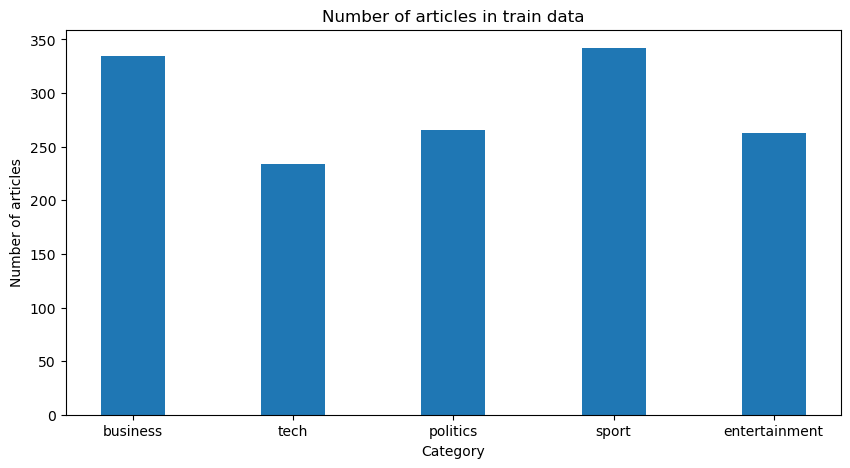

In [50]:
from collections import Counter

cat_count=Counter(train_df.Category)
cat=list(cat_count.keys())
counts=list(cat_count.values())

fig = plt.figure(figsize = (10, 5))
plt.bar(cat, counts, width = 0.4)

plt.xlabel("Category")
plt.ylabel("Number of articles")
plt.title("Number of articles in train data")
plt.show()

We see that the number of articles in each category is balanced and each category is well represented. 

This is good for our model because it wouldn't suffer from class imbalance.

### Plot word counts



In [53]:
# Find word count for each category
train_word_count = train_df[['Text', 'Category']]
train_word_count['wordcount'] = train_word_count.Text.apply(lambda x: len(x.split()))
train_word_count[['Category', 'wordcount']].groupby('Category').describe()

wordcount                                                        \
                  count        mean         std    min     25%    50%     75%   
Category                                                                        
business          335.0  334.274627  133.713125  145.0  253.00  304.0  391.50   
entertainment     263.0  335.444867  207.134549  144.0  229.00  271.0  380.00   
politics          266.0  451.642857  261.490785   90.0  320.25  445.0  527.75   
sport             342.0  336.877193  185.930006  116.0  211.50  296.5  416.75   
tech              234.0  509.222222  212.922747  188.0  345.25  461.5  633.75   

                       
                  max  
Category               
business        902.0  
entertainment  2448.0  
politics       3345.0  
sport          1671.0  
tech           1549.0

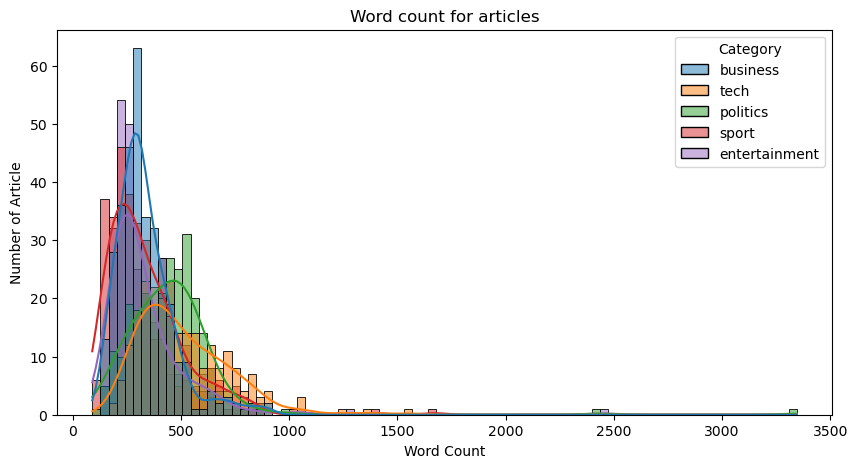

In [56]:
#Plot word count for each article
plt.figure(figsize=(10, 5))

sns.histplot(train_word_count, x='wordcount', hue='Category',kde=True)
plt.xlabel('Word Count')
plt.ylabel('Number of Article')
plt.title("Word count for articles")
plt.show()

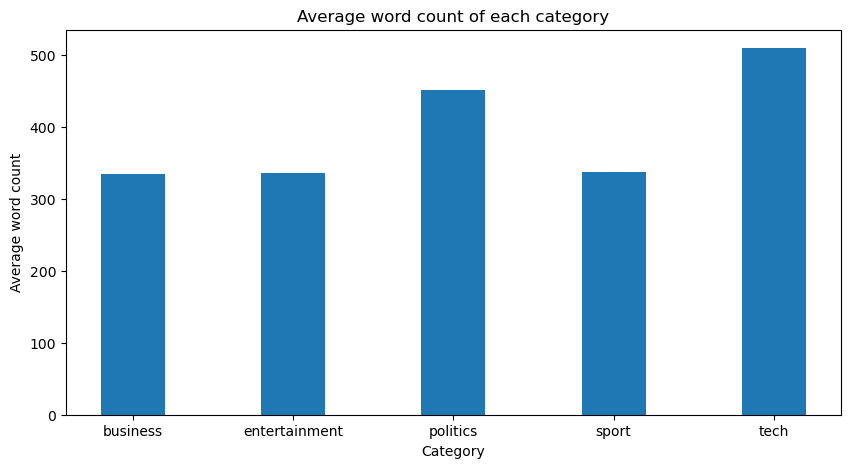

In [70]:
cat=list(train_word_count[['Category', 'wordcount']].groupby('Category').mean().index)
counts=list(train_word_count[['Category', 'wordcount']].groupby('Category').mean().wordcount)

fig = plt.figure(figsize = (10, 5))
plt.bar(cat, counts, width = 0.4)

plt.xlabel("Category")
plt.ylabel("Average word count")
plt.title("Average word count of each category")
plt.show()

### Statistical test for word counts

In [73]:
from scipy import stats
import statsmodels.stats.multicomp as mc

# Calculate multiple pairwise t test for word count for categories
comp1 = mc.MultiComparison(train_word_count["wordcount"], train_word_count["Category"])
tbl, a1, a2 = comp1.allpairtest(stats.ttest_ind, method= "bonf")
tbl

group1,group2,stat,pval,pval_corr,reject
business,entertainment,-0.0836,0.9334,1.0,False
business,politics,-7.1262,0.0,0.0,True
business,sport,-0.2087,0.8347,1.0,False
business,tech,-12.0246,0.0,0.0,True
entertainment,politics,-5.6612,0.0,0.0,True
entertainment,sport,-0.0894,0.9288,1.0,False
entertainment,tech,-9.2137,0.0,0.0,True
politics,sport,6.3191,0.0,0.0,True
politics,tech,-2.6769,0.0077,0.0768,False
sport,tech,-10.2946,0.0,0.0,True


We see that business, sport, and entertainment articles have a lower word count with the average of around 335. While politics and tech articles have a higher word count of 451 and 509.

The multiple t-test corrected with bonferroni correction has shown that the word count of business, sport, and entertainment articles are statistically lower than politics and tech articles (p<0.05).

This suggests that I should use frequency based embedding of words to train my models to avoid the effect of different word count on my model performance.






### Data cleaning

I have removed the duplicated data from the train data set. This has improved the class balance between categories. I think this data cleaning has helped imporved the data set before word embedding.

Another problem faced with text classification problems is stop word. Stop words are words that are not important and don't contribute to the model's ability to classify texts. Common english stop words include "the", "and", "a", "to" etc. 

I have decided to use the fuction TF-IDF to remove stop words. The sklearn fuction has a parameter "stop_words". I selected that paramenters to be English to use the package built-in English stop word dictionary and remove them. I also set the max_df to 0.95. This means that I would exclude words that appear in more than 95% of documents. As stop words are common, this parameter would also help remove stop words.

Those are my attemps of cleaning the data.

### Word embedding

EDA shows that the number of word counts are differnt in each category of article. This suggests that I should use frequency based embedding of words to train my models to avoid the effect of different word count on my model performance.

Based on the pervious EDA, I think Term Frequency - Inverse Document Frequency (TF-IDF) is the appropriate word embedding method for this project.

TF-IDF is a text analysis method to evaluate the importance of words in documents. TF-IDF is a frequency based embedding method that vectorizes the text using the frquency of its word occurrence.

Term frequency (TF) measures how frequent a word is used in the document. Words with higher frequency is considered more important. TF follows the following formula:

$TF = \frac{\text{number of word occurrence}}{\text{total number of words in document}}$

Inverse Document Frequency (IDF) measures how important a word is across all documents. Wordsthat appear in many documents are considered less important because they provide less information about the document. For example, "the" or "a" would be less important.

$IDF=log\big( \frac{\text{Total number of documents}}{\text{Number of documents containing the word}}\big)$

The final TF-IDF value is calculated for each word by multiplying TF and IDF. Terms with higher TF-IDF would be the ones that provide more information on the document and help identify that document.



In [84]:
# Vectorize text using TF-IDF
# max_df=0.95: Exclude words that appear in more than 95% of the documents
# min_df=2: include words that appear in at least 2 documents
# stop_words=english: exclude words that are non important or specific in english like "the","and","for" etc.
tfidf_vec = TfidfVectorizer(max_df=.95, min_df=2, stop_words='english')
tfidf = tfidf_vec.fit_transform(train_df.Text)

In [87]:
#Get feature name of tfidf
feature_names = tfidf_vec.get_feature_names_out()

words_df = pd.DataFrame(tfidf.toarray(), columns=feature_names)

print(words_df.shape)

words_df.head()

(1440, 13752)


,00,000,000m,000th,007,01,0100,0130,028,03,...,zoe,zola,zombie,zombies,zone,zones,zoom,zooms,zurich,zvonareva
0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.024543,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.019484,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Our word embedding matrix has 13752 terms and 1440 articles. 

This is a large sparse matrix with most terms being 0.



In [150]:
# Show the top 20 average TF-IDF words for each category of articles
# business
business_words=words_df[list(train_df.Category=="business")].mean(axis=0)
business_words=business_words[np.argsort(-business_words)][0:20]

# entertainment
entertainment_words=words_df[list(train_df.Category=="entertainment")].mean(axis=0)
entertainment_words=entertainment_words[np.argsort(-entertainment_words)][0:20]

# politics
politics_words=words_df[list(train_df.Category=="politics")].mean(axis=0)
politics_words=politics_words[np.argsort(-politics_words)][0:20]

# sport
sport_words=words_df[list(train_df.Category=="sport")].mean(axis=0)
sport_words=sport_words[np.argsort(-sport_words)][0:20]

# tech
tech_words=words_df[list(train_df.Category=="tech")].mean(axis=0)
tech_words=tech_words[np.argsort(-tech_words)][0:20]


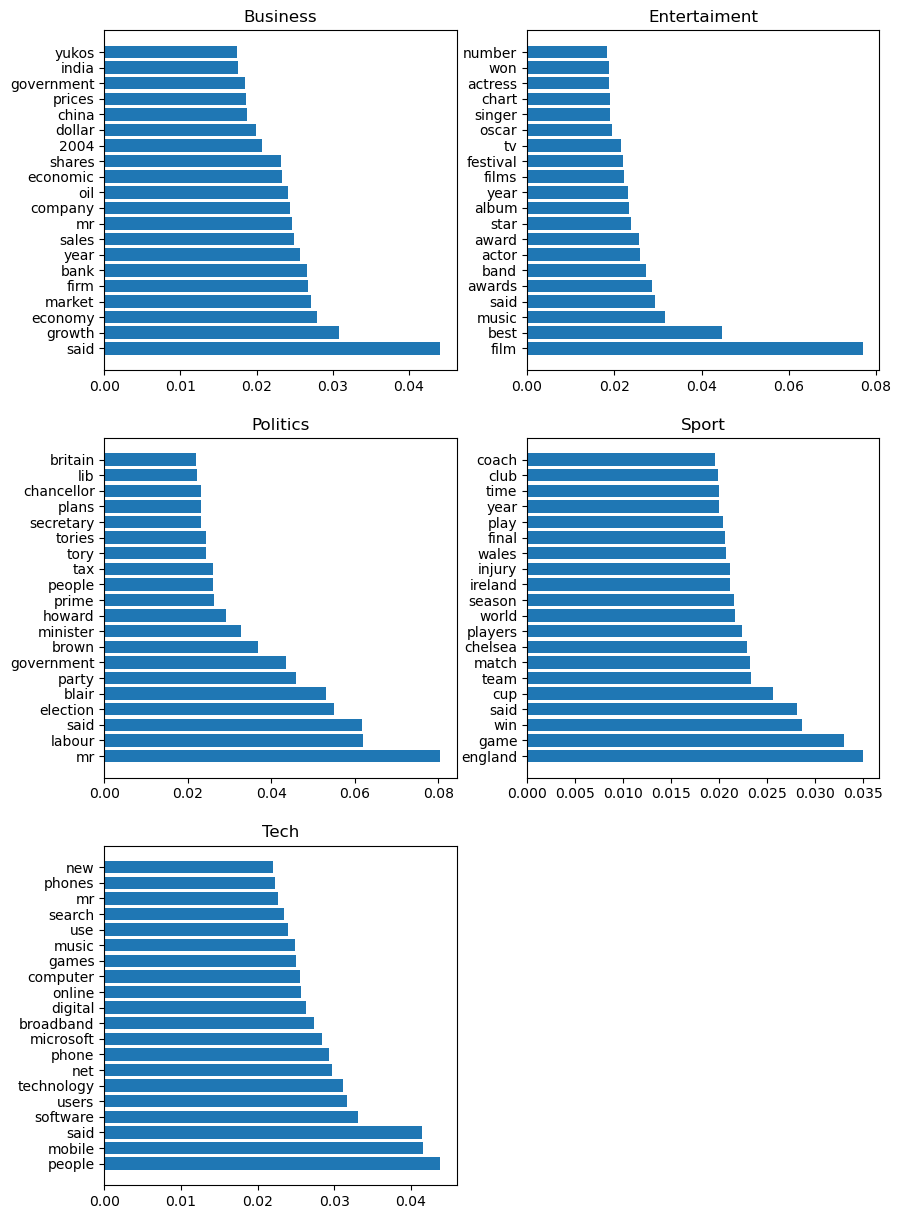

In [158]:
# Plot highest average TF-IDF words for each category

fig = plt.figure(figsize = (10, 15))

x = np.array(business_words.keys())
y = np.array(business_words)
plt.subplot(3, 2, 1)
plt.barh(x, y)
plt.title("Business")

x = np.array(entertainment_words.keys())
y = np.array(entertainment_words)
plt.subplot(3, 2, 2)
plt.barh(x, y)
plt.title("Entertaiment")

x = np.array(politics_words.keys())
y = np.array(politics_words)
plt.subplot(3, 2, 3)
plt.barh(x, y)
plt.title("Politics")

x = np.array(sport_words.keys())
y = np.array(sport_words)
plt.subplot(3, 2, 4)
plt.barh(x, y)
plt.title("Sport")

x = np.array(tech_words.keys())
y = np.array(tech_words)
plt.subplot(3, 2, 5)
plt.barh(x, y)
plt.title("Tech")


plt.show()

Initial inspection of the top 20 important words of each category makes sense. 

A lot of words related to the category show up as top important. This suggests that our word embedding has successfully identify important words and should be good for model fitting.

# Non negative matrix factorization

I will fit the word matrix into the unsupervised machine learning model Non negative matrix factorization. 

To answer the question from the guide: when you train the unsupervised model for matrix factorization, should you include texts (word features) from the test dataset or not as the input matrix? Why or why not?

I think when training with unsupervised model, using texts from both the train and test set is acceptable and can increase the model accuracy. This is because unlike supervised learning, we don't provide the model with labels of the data. Therefore, the unsupervised model can't overfit the test data and give us an falsely high accuracy in the test set. Including both train and test data can imporve the model accuracy because it increase the training size.

Therefore, I will create a word feature matrix including both train and test set. 


In [167]:
#Combine train and test Text
combined_text=pd.concat([train_df.Text, test_df.Text])

# Embedd text from combined data
tfidf_vec_combined = TfidfVectorizer(max_df=.95, min_df=2, stop_words='english')
tfidf_combined = tfidf_vec_combined.fit_transform(combined_text)
feature_names_combined = tfidf_vec_combined.get_feature_names_out()

words_df_combined = pd.DataFrame(tfidf_combined.toarray(), columns=feature_names_combined)

print(words_df_combined.shape)
words_df_combined.head()

(2175, 17243)


,00,000,000m,000th,007,01,0100,011,0130,02,...,zola,zombie,zombies,zone,zones,zoom,zooms,zurich,zvonareva,zvyagintsev
0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.024422,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.019664,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


I will apply the non negative matrix factorization (NMF) to the TF-IDF matrix of the combined text. I will select the number of component as 5 because we know that there are 5 different categories of articles.

I will choose the default parameters as my initial model, then I will tune the hyperparameters later.


In [169]:
#Fit the model
nmf_initial = NMF(n_components=5, random_state=21)

nmf_output = nmf_initial.fit_transform(words_df_combined)

#Get predicted result of train data

nmf1_predicted=nmf_output.argmax(axis=1)[0:train_df.shape[0]]

I will define a method to match the label of category to the predicted value and find the best accuracy score

In [183]:
def label_permute_compare(ytrue,yp,n=5):
    # Get unique labels of array
    labels=np.unique(ytrue)
    List=[]
    for i in itertools.permutations(range(n)):
        ytrue_copy=np.copy(ytrue)
        for j in range(n):
            ytrue_copy[ytrue_copy == labels[j]] = i[j]
        ytrue_copy=ytrue_copy.astype(int)
        acc=accuracy_score(ytrue_copy, yp)
        List.append((i,acc))
    acc=sorted(List, key=lambda x: x[1],reverse=True)[0]
    return acc


Accuracy:  0.9159722222222222


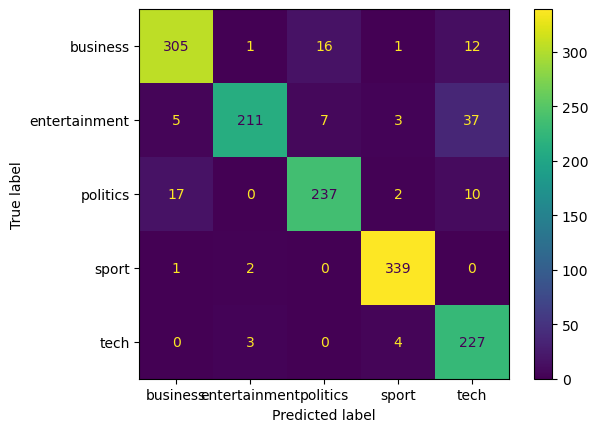

In [186]:
#Get accuracy and label order
labelorder, acc= label_permute_compare(train_df.Category,nmf1_predicted)
print("Accuracy: ",acc)

# Show confusion matrix
y_true=np.array(train_df.Category)
y_pred= nmf1_predicted.astype('str')
Type=np.unique(y_true)
for i in range(len(Type)):
    y_pred[y_pred==str(labelorder[i])]=Type[i]

con_mat=confusion_matrix(y_true, y_pred)
disp=ConfusionMatrixDisplay(con_mat,display_labels=Type)
disp.plot()
plt.show()

The initial model with default parameters have a high accuracy score of 0.91.

This is impressive as NMF model was able to identify and classify different articles using the TF-IDF matrix. 

We see that the model still missclassifies some of the articles. For example, 37 tech articles are missclassified as entertainment. I think the default parameters are not the best so I will perform parameter tuning to imporve the model.

I will use GridCV for parameter tuning. First, I will write a custom accuracy score fucntion for GridCV to match the predicted values with correct labels

In [191]:
def custom_score(model, X, y):
    W = model.transform(X)
    pred = np.argmax(W, axis=1)
    return label_permute_compare(y, pred)[1]

I will tune the beta loss parameter and alpha weight parameter. 

I selected the solver as mu because it can solve both frobenius and kullback-leibler loss function.

In [207]:
param = { 'n_components': [5],
    'beta_loss': ['frobenius', 'kullback-leibler'],
    'solver': ['mu'],
    'alpha_W': [0, 0.05, 0.1]
}

nmf = NMF(random_state=21)

grid_search = GridSearchCV(nmf, param, scoring=custom_score, cv=5)
grid_search.fit(words_df, train_df.Category)

GridSearchCV(cv=5, estimator=NMF(random_state=21),
             param_grid={'alpha_W': [0, 0.05, 0.1],
                         'beta_loss': ['frobenius', 'kullback-leibler'],
                         'n_components': [5], 'solver': ['mu']},
             scoring=<function custom_score at 0x7fed35376290>)

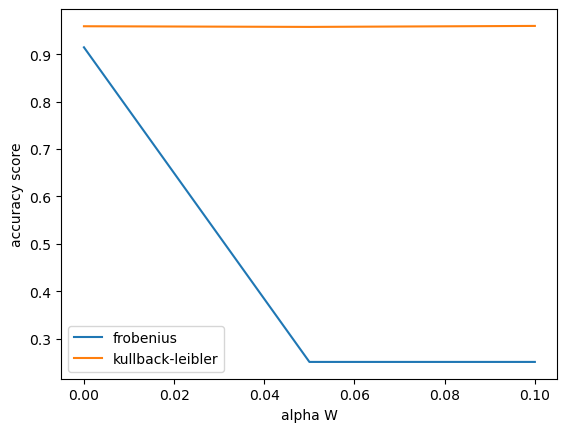

Best parameters: 
{'alpha_W': 0.1, 'beta_loss': 'kullback-leibler', 'n_components': 5, 'solver': 'mu'}


In [209]:
# Plot parameter tuning models
cv_res=pd.DataFrame(grid_search.cv_results_)

plt.plot([0, 0.05, 0.1], np.array(cv_res[cv_res.param_beta_loss=="frobenius"].mean_test_score), label = "frobenius") 
plt.plot([0, 0.05, 0.1], np.array(cv_res[cv_res.param_beta_loss=="kullback-leibler"].mean_test_score), label = "kullback-leibler") 
plt.legend()
plt.xlabel('alpha W') 
plt.ylabel('accuracy score') 
plt.show()

print("Best parameters: ")
print(grid_search.best_params_)


After cross validating with 5 fold, the best parameters are alpha weight of 0.1 and kullback-leibler beta loss.

We see that the kullback-leibler loss function performs better than frobenius. The accuracy increases as alpha weight increases in kullback-leibler beta loss models. 

Therefore, I will select alpha weight of 0.1 and kullback-leibler beta loss and refit the model with the combined dataset. Let's see how the accuracy improves compared to the my initial model

In [213]:
#Refit the model with the whole dataset

nmf_final = NMF(n_components=5,beta_loss="kullback-leibler",solver="mu",alpha_W = 0.1, random_state=21)

nmf_final_output = nmf_final.fit_transform(words_df_combined)

nmf2_predicted=nmf_final_output.argmax(axis=1)[0:train_df.shape[0]]


Accuracy:  0.9631944444444445


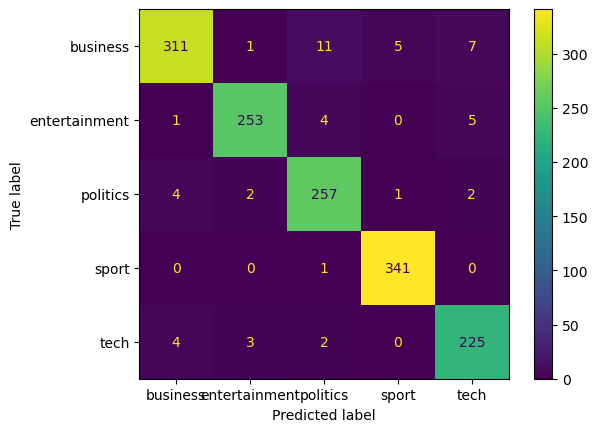

In [214]:
#Get accuracy and label order
labelorder, acc= label_permute_compare(train_df.Category,nmf2_predicted)
print("Accuracy: ",acc)

# Show confusion matrix
y_true=np.array(train_df.Category)
y_pred= nmf2_predicted.astype('str')
Type=np.unique(y_true)
for i in range(len(Type)):
    y_pred[y_pred==str(labelorder[i])]=Type[i]

con_mat=confusion_matrix(y_true, y_pred)
disp=ConfusionMatrixDisplay(con_mat,display_labels=Type)
disp.plot()
plt.show()

We see that this model after hyperparameter tuning performs much better than the initial model. 

The accuracy increases from 0.91 to 0.96. The model can classify the articles with a high accuracy and low errors. This is a great improvement from the initial model.

Therefore, this will be my final unsupervised model.

In [246]:
#Get accuracy to test data by submission to kaggle
nmf2_predicted_test=nmf_final_output.argmax(axis=1)[train_df.shape[0]:combined_text.shape[0]]
Type=np.unique(np.array(train_df.Category))
y_pred= nmf2_predicted_test.astype('str')
for i in range(len(Type)):
    y_pred[y_pred==str(labelorder[i])]=Type[i]
#Create submission file
nmf2_test = pd.DataFrame({'ArticleID': np.array(test_df.ArticleId), 'Category': y_pred})

#Export submission file
nmf2_test.to_csv('nmf_test.csv', index=False) 

After submission to kaggle, the NMF model achieved an accuracy of 0.96326 for the test data.

This is a good accuracy score for the model. I will use this accuracy score to compare with other supervised models.

# Supervised learning

I will fit 2 supervised learning models to compare to the unsupervised learning model

## Logistic Regression

The first supervised learning model I fit is Logistic regression. This is one of the simplest model of supervised learning.

Because supervised learning uses the label of data to fit, I will only fit the training data to prevent the model from overfitting the test data and gives falsely high accuracy.


In [247]:
#Train y
y_train = train_df['Category']

#Fit model
log_reg = LogisticRegression(max_iter=2000).fit(tfidf_combined[0:len(y_train)], y_train)

Logistic Regression Training Accuracy: 0.9972222222222222


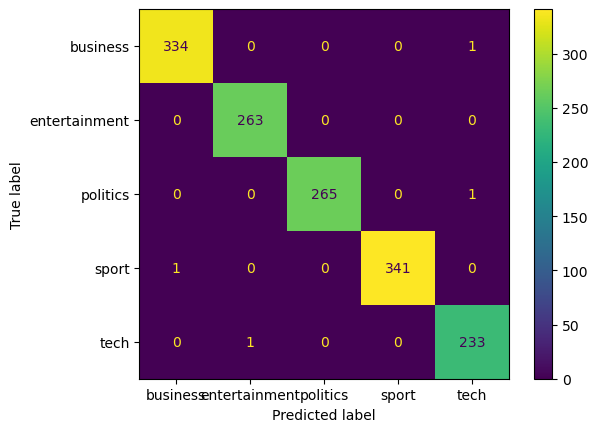

In [252]:
#Get train prediction
y_train_pred = log_reg.predict(tfidf_combined[0:len(y_train)])

lr_train_acc = accuracy_score(y_train, y_train_pred)

print(f'Logistic Regression Training Accuracy: {lr_train_acc}')

con_mat=confusion_matrix(y_train, y_train_pred)
disp=ConfusionMatrixDisplay(con_mat,display_labels=Type)
disp.plot()
plt.show()

In [254]:
#Get test prediction
y_test_pred = log_reg.predict(tfidf_combined[len(y_train):tfidf_combined.shape[0]])

#Export and submit to kaggle for test accuracy
lr_test = pd.DataFrame({'ArticleID': np.array(test_df.ArticleId), 'Category': y_test_pred})
lr_test.to_csv('lr_test.csv', index=False) 

We see that the performance of logistic regression is very good.

When classifying the training data, the model achieved a high accuracy score of 0.997. The model only missclassify a few article. This is a very good result for such simple model.

After submission to Kaggle, The Logistic Regression model achieved an accuracy score of 0.983. This score is a bit lower than the training data but it is still very good.

Compare to unsupervised learning, Logistic Regression performs significantly better.

## Random Forest

Next, I will fit the data to a random forest classifer model. 

This model uses a random subset of the data to build multiple decision trees. This model also uses a random subset of features for each tree. Random forest model is preferable for its robustness and low risk of overfitting data.

In [261]:
#Fit model
RF=RandomForestClassifier(n_estimators=1000,random_state=21).fit(tfidf_combined[0:len(y_train)], y_train)


Random Forest Training Accuracy: 1.0


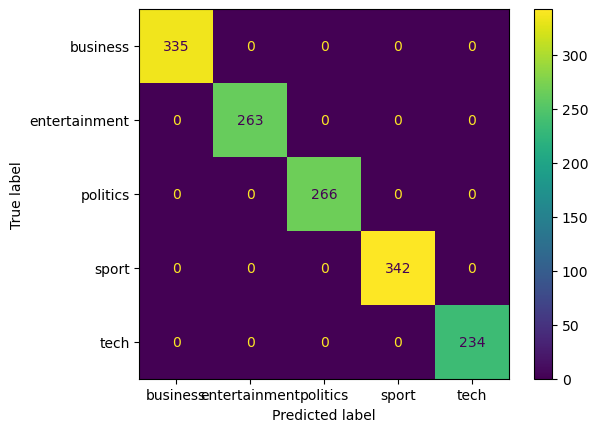

In [262]:
#Get train prediction
y_train_pred = RF.predict(tfidf_combined[0:len(y_train)])

rf_train_acc = accuracy_score(y_train, y_train_pred)

print(f'Random Forest Training Accuracy: {rf_train_acc}')

con_mat=confusion_matrix(y_train, y_train_pred)
disp=ConfusionMatrixDisplay(con_mat,display_labels=Type)
disp.plot()
plt.show()

In [263]:
#Get test prediction
y_test_pred = RF.predict(tfidf_combined[len(y_train):tfidf_combined.shape[0]])

#Export and submit to kaggle for test accuracy
lr_test = pd.DataFrame({'ArticleID': np.array(test_df.ArticleId), 'Category': y_test_pred})
lr_test.to_csv('rf_test.csv', index=False) 

We see that the performance of Random Forest is very good.

When classifying the training data, the model achieved a perfect accuracy score of 1. The model doesn't missclassify any of the article. This is a perfect score for training. However, testing accuracy would be the more important accuracy metric.

After submission to Kaggle, The Random Forest model achieved an accuracy score of 0.969. This score is a bit lower than the training data but it is still very good.

Compare to unsupervised learning, Random forest performs significantly better in the training dataset but similar in the test data set.

## Comparing 3 models

### Training Accuracy

Let's compare the training accuracy of the 3 models

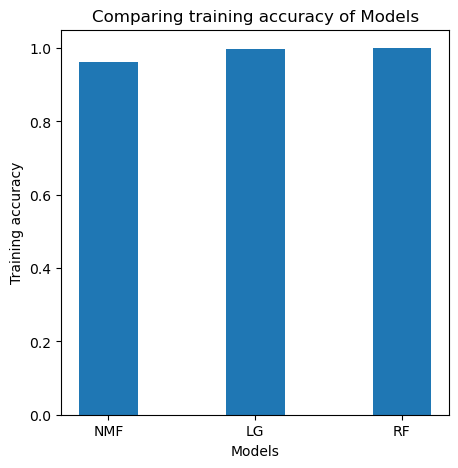

In [266]:
models=["NMF","LG","RF"]
acc=[0.963,0.997,1]

fig = plt.figure(figsize = (5, 5))
plt.bar(models, acc, width = 0.4)

plt.xlabel("Models")
plt.ylabel("Training accuracy")
plt.title("Comparing training accuracy of Models")
plt.show()

We see that the training accuracy of Random Forest model is the highest. It achieves perfect accuracy score of 1 without any missclassification.

Training accuracy of Logistic Regression is a bit lower and the training accuracy of NMR is the lowest.

### Testing accuracy

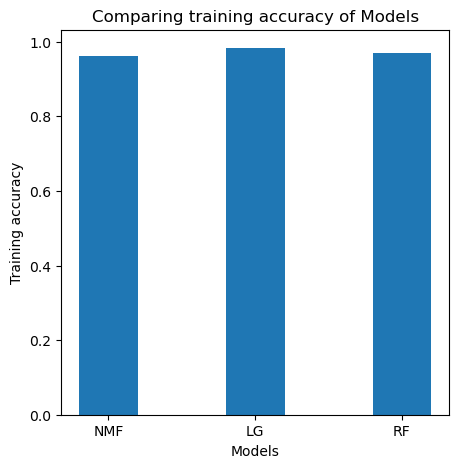

In [265]:
models=["NMF","LG","RF"]
acc=[0.963,0.983,0.969]

fig = plt.figure(figsize = (5, 5))
plt.bar(models, acc, width = 0.4)

plt.xlabel("Models")
plt.ylabel("Training accuracy")
plt.title("Comparing training accuracy of Models")
plt.show()

For the testing accuracy, Logistic Regession achieves the highest accuracy of 0.983. 

Random forest and NMF have similar accuracies of 0.96.

## Discussion

This suggests that Logistic Regression is the best performing model of the 3. Even though it might not have the highest training accuracy, Logistic Regression still predicts well in the testing data.

This indicates that Random Forest model is overfitted. This is because Random Forest model has a perfect training score but lower testing score. I believe this model is overfitted due to model design. The depth of classification trees is not limited so the model might have overfitted the training data.

Compared to supervised models, NMF model has the lowest risk of overfitting because it doesn't use data label in the process of model fitting. This is why the accuracy is robust in the testing and training data sets. This is an advantage of unsupervised model.

However, in this case, I would select Logistic Regression as the best performing model. This is because this model is the simplest model with the highest accuracy. It's a rule of thumb that we select the simple model with high accuracy.
